# Visualising relatedness with an msprime simulation

Let's consider a simple pedigree with two full siblings and their parents, along with two unrelated individuals. Using code by Aaron Ragsdale, we can simulate the pedigree and recapitate into a standard Wright-Fisher simulation. This will be our dataset for testing out visualisations of relatedness.

In [3]:
#draw_pedigree function from tutorial
import msprime
import networkx as nx
import io
import tskit
import matplotlib.pyplot as plt

def draw_pedigree(ped_ts):

    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

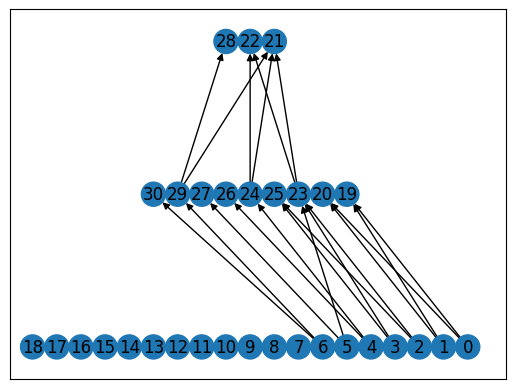

In [30]:
ped_txt = """\
# id parent0 parent1 time is_sample
0	19	20	0.0	1
1	19	20	0.0	1
2	23	25	0.0	1
3	23	25	0.0	1
4	24	26	0.0	1
5	23	27	0.0	1
6	29	30	0.0	1
7	.	.	0.0	1
8	.	.	0.0	1
9	.	.	0.0	1
10	.	.	0.0	1
11	.	.	0.0	1
12	.	.	0.0	1
13	.	.	0.0	1
14	.	.	0.0	1
15	.	.	0.0	1
16	.	.	0.0	1
17	.	.	0.0	1
18	.	.	0.0	1
19	.	.	1.0	0
20	.	.	1.0	0
21	.	.	2.0	0
22	.	.	2.0	0
23	21	22	1.0	0
24	21	22	1.0	0
25	.	.	1.0	0
26	.	.	1.0	0
27	.	.	1.0	0
28	.	.	2.0	0
29	21	28	1.0	0
30	.	.	1.0	0
"""
pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=1000)
draw_pedigree(pedigree.tree_sequence())


In [36]:
ts0 = msprime.sim_ancestry(initial_state=pedigree, model="fixed_pedigree", random_seed=1,
                           recombination_rate=0.001)

print(ts0.first().draw_text())
ts0

         45     43   42    56                                                                           
          ┃      ┃    ┃     ┃                                                                           
39 40 38 47 5150 ┃53  ┃ 54  ┃ 61                                                                        
┃  ┏┻┓ ┃ ┏┻┓ ┃ ┃ ┃ ┃  ┃  ┃  ┃  ┃                                                                        
0  1 3 2 4 6 5 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37



In [40]:
ts = msprime.sim_ancestry(population_size=10000, initial_state=ts0, model="dtwf", random_seed=1,
                         recombination_rate=1e-5)
ts

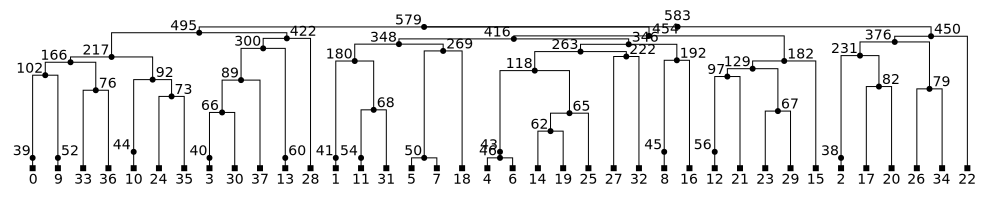

In [9]:
ts.first().draw_svg(size=(1000,200), time_scale='log_time')

## Add metadata

To match the GEL data with pedigrees, let's add metadata for the biological relationship to proband and family id. We'll use this to make better plot legends.

## Plot closest neighbours

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns

def make_span_df(ts, n_per_sample):
    sample_span = np.zeros((ts.num_samples, ts.num_samples))

    for tree in ts.simplify().trees(sample_lists=False):
        #print(f"Visiting tree {tree.index}")
        if tree.has_single_root:
            for u in ts.samples():
                #print(f"  Checking neighbours for sample {u} under parent {tree.parent(u)}")
                for nearest in tree.samples(tree.parent(u)):
                    if nearest != u:
                        #print(f"    {nearest} is a neighbour of {u}")
                        #print(f"    Adding {tree.span} to the sample span between {u} and {nearest}")
                        sample_span[u, nearest] += tree.span
    sample_span = sample_span / ts.sequence_length
    samples = [str(s) for s in ts.samples()]
    
    #Construct the dataframe
    span_df = pd.DataFrame(sample_span.T, columns = samples)
    span_df['sample'] = samples
    
    #Melt the dataframe for plotting
    span_melted = span_df.melt(id_vars=['sample'])
    span_melted.set_index('sample',drop=True, inplace=True)
    topn = span_melted.groupby('variable')['value'].nlargest(n_per_sample).reset_index()
    topn.columns = ['Sample','Neighbour','Value']
    #Normalise spans so that the bars are of the same height
    topn['Norm_Value'] = topn['Value']/ topn.groupby('Sample')['Value'].transform('sum')
    topn.sort_values(by='Sample', inplace=True, key=lambda x : x.astype(int))
    return topn

def plot_span_df(df, palette = 'tab20', normaliseQ = False):
    #neighbours_list ordered for plotting
    neighbours = df['Neighbour'].drop_duplicates().to_list()
    neighbours.sort(key = int)
    
    #using histplot because it can create stacked bar charts nicely
    if normaliseQ:
        ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Norm_Value',
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)
    else:
        ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Value',
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(xlabel='Sample', ylabel='Span')

    plt.show()

def plot_span_ts(ts, n_per_sample=3, palette='tab20', normaliseQ=False):
    df = make_span_df(ts, n_per_sample)
    plot_span_df(df, palette, normaliseQ)

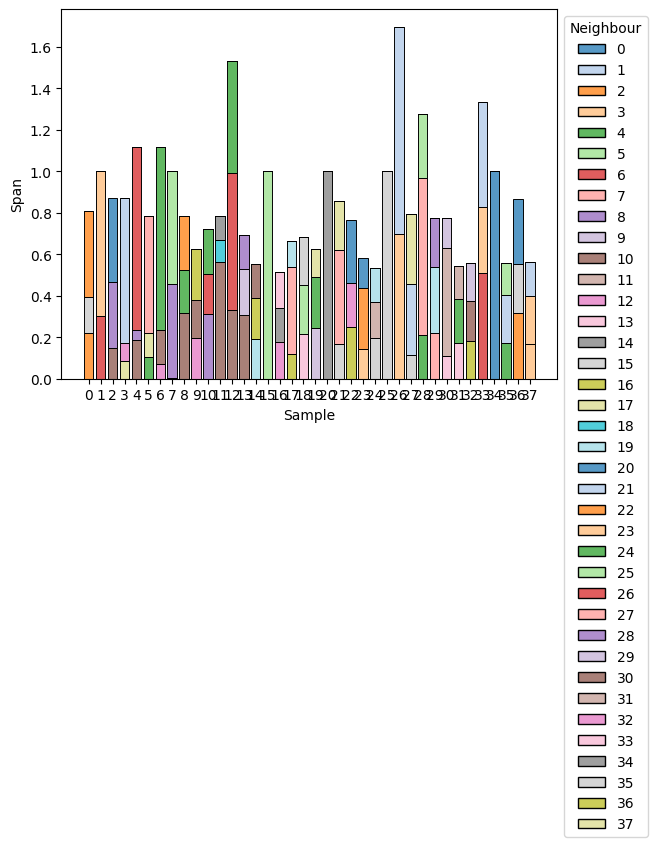

In [39]:
plot_span_ts(ts)